# Dropout technique


* Dropout is a regularization technique for improving neural networks by reducing overfitting

* Dropout technique involves randomly reducing inputs or interconnecting neurons in each training step

## A simple example

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np

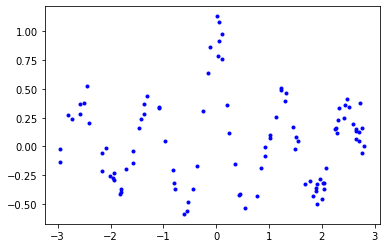

In [ ]:
n_samples = 100
X = np.random.uniform(size=(n_samples, 1), low=-3, high=3)
y = np.random.normal(np.cos(5.*X) / (np.abs(X) + 1.), 0.1).ravel()
X_pred = np.atleast_2d(np.linspace(-3., 3., num=100)).T

plt.plot(X, y, "b.")

In [ ]:
class DropoutModel(tf.keras.Model):
  def __init__(self, hidden_size, dropout_rate, **kwargs):
    super().__init__(**kwargs)
    self.layer1 = tf.keras.layers.Dense(hidden_size, activation='relu')
                                        # kernel_regularizer = tf.keras.regularizers.l2(1e-4))
    self.layer2 = tf.keras.layers.Dense(hidden_size, activation='relu')
                                        # kernel_regularizer = tf.keras.regularizers.l2(1e-4))
    self.layer3 = tf.keras.layers.Dense(1)
    self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)
  def call(self, x):
    z = self.layer1(x)
    z = self.dropout(z)
    z = self.layer2(z)
    z = self.dropout(z)
    z = self.layer3(z)
    return z

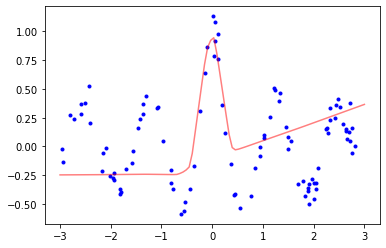

In [ ]:
hidden_size = 300
dropout_rate = 0.
model = DropoutModel(hidden_size, dropout_rate)
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
model.fit(X, y, epochs=50, verbose=False)

plt.figure()
plt.plot(X, y, "b.")
plt.plot(X_pred, model(X_pred), 'r-', alpha=1/2)
plt.show()

## Dropout as a Bayesian approximation

* Dropout is a useful approach to capture and model the uncertainty of a neural networks. 

* [Yarin Gal, Zoubin Ghahramani](https://arxiv.org/abs/1506.02142) shows that applying dropout to a neural network is equivalent to approximate variational inference (e.g. using Gaussian process).

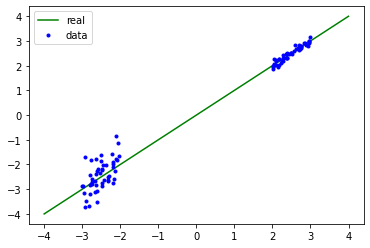

In [ ]:
# data with uncertainty
x_real = np.linspace(-4, 4, 100)
y_real = x_real

x_train1 = np.random.uniform(-3, -2, 50)
y_train1 = x_train1 + np.random.randn(x_train1.shape[0])*0.5
x_train2 = np.random.uniform(2, 3, 50)
y_train2 = x_train2 + np.random.randn(x_train2.shape[0])*0.1
x_train = np.concatenate([x_train1, x_train2])
y_train = np.concatenate([y_train1, y_train2])

plt.plot(x_real, y_real, 'g-', label='real')
plt.plot(x_train, y_train, 'b.', label='data')
plt.legend()
plt.show()

The data in (-3, -2) has higher variance than the data in (2, 3), which represents the aleatoric uncertainty inherent in the data. 

In [ ]:
def createDropoutModel(droprate):
  inputs = tf.keras.layers.Input(shape=(1,))
  z = tf.keras.layers.Dense(10, activation='relu', 
                            kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
  for i in range(3):
    z = tf.keras.layers.Dropout(droprate)(z, training=True)
    z = tf.keras.layers.Dense(20, activation='relu', 
                              kernel_regularizer=tf.keras.regularizers.l2(1e-4))(z)
  z = tf.keras.layers.Dropout(droprate)(z, training=True)
  z = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(z)
  return tf.keras.Model(inputs, z)

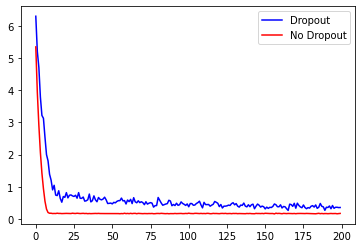

In [ ]:
model_drop = createDropoutModel(0.1)
model_no_drop = createDropoutModel(0)

model_drop.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_drop = model_drop.fit(x_train, y_train, batch_size=10, epochs=200, verbose=False)

model_no_drop.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_no_drop = model_no_drop.fit(x_train, y_train, batch_size=10, epochs=200, verbose=False)

plt.plot(history_drop.history['loss'], 'b', label="Dropout")
plt.plot(history_no_drop.history['loss'], 'r', label="No Dropout")
plt.legend()
plt.show()

The model with dropout has a slightly higher loss and a more stochastic behavior, which overfits less. With random dropout, we expect the predictions of input values without training data to have higher variance, which can be used to compute the epistemic uncertainty of the model. 

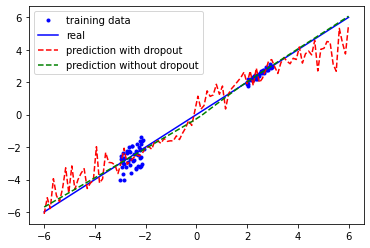

In [ ]:
x_test = np.linspace(-6,6,100)
pred_drop = model_drop.predict(x_test)
pred_no_drop = model_no_drop.predict(x_test)

plt.plot(x_train, y_train, 'b.', label="training data")
plt.plot(x_test, x_test, 'b-', label="real")
plt.plot(x_test, pred_drop, 'r--', label="prediction with dropout")
plt.plot(x_test, pred_no_drop, 'g--', label="prediction without dropout")
plt.legend()
plt.show()

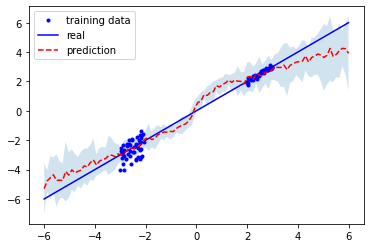

In [ ]:
# estimate epistemic uncertainty using Monte Carlo (Dropout) method

n = 10
predictions = []
for i in range(n):
  predictions.append(model_drop.predict(x_test))
predictions = np.array(predictions)
mu = np.squeeze(np.mean(predictions, axis=0))
std = np.squeeze(np.std(predictions, axis=0))

plt.plot(x_train, y_train, 'b.', label="training data")
plt.plot(x_test, x_test, 'b-', label="real")
plt.plot(x_test, mu, 'r--', label="prediction")
plt.fill_between(x_test, mu - 2*std, mu + 2*std, alpha=0.2)
plt.legend()
plt.show()

The epistemic uncertainty is large in the regions with less training samples. 

# Batch Normalization

Batch normalization is a similar regularization method as Dropout.

It involves unit-wise operation:

$$y_i = \frac{x_i-E[x_i]}{\sqrt{\text{Var}[x_i] + \epsilon}} * \gamma_i + \beta_i$$

where the expectation and variance are calculated over the mini-batch, and $\boldsymbol{\gamma}, \boldsymbol{\beta}$ are learnable parameters of the same size as input $\mathbf{x}$. 

* A batch normalized neural network can be seen as an approximate Bayesian model.

* [This paper](https://arxiv.org/abs/1802.06455) shows that applying batch normalization to a neural network is equivalent to approximate inference in Bayesian models. 

* A Monte Carlo Batch Normalization approach can be used to estimate the model uncertainty. 

In [ ]:
def createBNModel():
  inputs = tf.keras.layers.Input(shape=(1,))
  z = tf.keras.layers.Dense(10, activation='relu', 
                            kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
  for i in range(3):
    z = tf.keras.layers.BatchNormalization()(z)
    z = tf.keras.layers.Dense(20, activation='relu', 
                              kernel_regularizer=tf.keras.regularizers.l2(1e-4))(z)
  z = tf.keras.layers.BatchNormalization()(z)
  z = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(z)
  return tf.keras.Model(inputs, z)

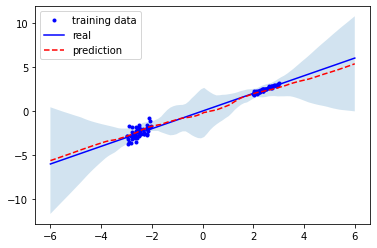

In [ ]:
# Monte Carlo Batch Normalization for uncertainty estimation

n = 10
predictions = []
for i in range(n):
  model_bn = createBNModel()
  model_bn.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model_bn.fit(x_train, y_train, batch_size=10, epochs=50, verbose=False)
  predictions.append(model_bn.predict(x_test))
predictions = np.array(predictions)
mu = np.squeeze(np.mean(predictions, axis=0))
std = np.squeeze(np.std(predictions, axis=0))

plt.plot(x_train, y_train, 'b.', label="training data")
plt.plot(x_test, x_test, 'b-', label="real")
plt.plot(x_test, mu, 'r--', label="prediction")
plt.fill_between(x_test, mu - 2*std, mu + 2*std, alpha=0.2)
plt.legend()
plt.show()

The result agrees with that the model (epistemic) uncertainty is high at the input values with no training data. 

# Other uncertainty estimation methodologies

Some survey papers

* https://arxiv.org/abs/2011.06225

* https://core.ac.uk/download/pdf/334459205.pdf

### Ensemble techniques
* Require plentiful computing resources


### Distance-aware deep learning

* https://arxiv.org/abs/2006.10108

### Deep Gaussian process

* http://proceedings.mlr.press/v31/damianou13a

### Test-time data augmentation

* https://openreview.net/forum?id=rJZz-knjz